# Spectrum Plugins

The **SpectrumLike** plugin is designed to handle binned photon/particle spectra. It comes in three basic classes:

* **SpectrumLike**: Generic binned spectral
* **DispersionSpectrumLike**: Generic binned spectra with energy dispersion
* **OGIPLike**: binned spectra with dispersion from OGIP PHA files

The functionality of all three plugins is the same.

## SpectrumLike

The most basic spectrum plugin is **SpectrumLike** which handles spectra with and without backgrounds. There are six basic features of a spectrum:

* the energy boundries of the bins,
* the data in these energy bins,
* the statistical properties of the total spectrum
    * Possion (counts are meausred in an on/off fashion),
    * Gaussian (counts are the result of a masking process or a fit),
* the exposure,
* the background (and its associated statistical properties),
* and any known systematic errors associated with the total or background spectrum.

Let's start by examining an observation where the total counts are Poisson distributed and the measured background ground has been observed by viewing an off-source region and hence is also Poisson.


In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%%capture
import matplotlib.pyplot as plt

from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()
silence_warnings()

We will construct a simulated spectrum over the energy range 10-1000 keV. The spectrum will have logrithmic energy boundaries.

We will simulate a blackbody source spectrum on top of powerlaw background.

In [4]:
energies = np.logspace(1, 3, 51)

low_edge = energies[:-1]
high_edge = energies[1:]

# get a blackbody source function
source_function = Blackbody(K=9e-2, kT=20)

# power law background function
background_function = Powerlaw(K=1, index=-1.5, piv=100.0)

spectrum_generator = SpectrumLike.from_function(
    "fake",
    source_function=source_function,
    background_function=background_function,
    energy_min=low_edge,
    energy_max=high_edge,
)

### The count spectrum

Let's examine a few properties about the count spectrum including the contents stored in the plugin, viewing the count distribution, masking channels, and rebinnined the spectrum.


We can examine the contents of our plugin with the display function:

In [5]:
spectrum_generator.display()

,0
n. channels,50
total rate,1915.0
total bkg. rate,294.0
bkg. exposure,1.0
bkg. is poisson,True
exposure,1.0
is poisson,True
background,profiled
significance,36.462119
src/bkg area ratio,1.0


These properties are accessible from the object. For example:

In [6]:
print(spectrum_generator.exposure)
print(spectrum_generator.significance)
print(spectrum_generator.observed_counts)

1.0
36.462119403339464
[ 36  33  24  31  32  59  42  55  48  43  64  72  88  77  80  87  92 116
  88  83  93  91  86  81  63  42  42  45  17  18  21   9  10   2   2   4
   4   1   5   2   4   2   5   1   1   2   0   2   9   1]


To view the count spectrum, we call the *view_count_spectrum* method:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


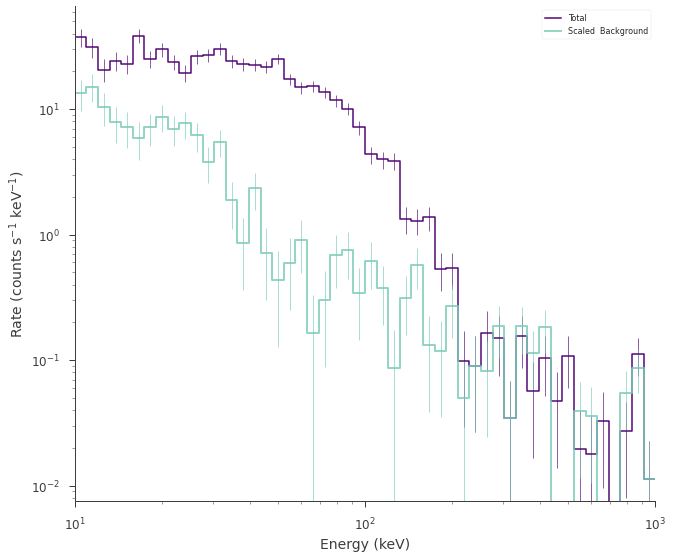

In [7]:
fig = spectrum_generator.view_count_spectrum()

It is even possible see which channels are above a given significance threshold. Red regions are below the supplied significance regions.

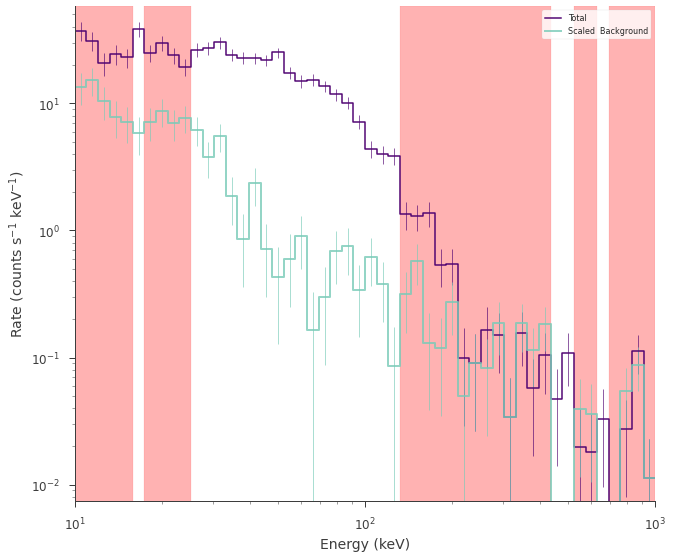

In [8]:
fig = spectrum_generator.view_count_spectrum(significance_level=5)

**Note:** In 3ML, the **Significance** module is used to compute significnaces. When total counts ($N_{\rm on}$) are Poisson distributed and the background or off-source counts ($N_{\rm off}$) are also Poisson distributed, the significance in $\sigma$ is calculated via the likelihood ratio derived in [Li & Ma (1980)](http://adsabs.harvard.edu/abs/1983ApJ...272..317L):

$$ \sigma = \sqrt{-2 \log \lambda} = \sqrt{2} \left( N_{\rm on} \log \left[ \frac{1+\alpha}{\alpha} \frac{N_{\rm on}}{N_{\rm on}+N_{\rm off}} \right] + N_{\rm off} \log \left[ (1 + \alpha)\frac{N_{\rm off}}{N_{\rm on}+N_{\rm off}} \right] \right)$$

In the case that the background is Gaussian distributed, an equivalent likelihood ratio is used (see Vianello *in prep*).

#### Selection

Many times, there are channels that we are not valid for analysis due to poor instrument characteristics, overflow, or systematics. We then would like to mask or exclude these channels before fitting the spectrum. We provide several ways to do this and it is useful to consult the docstring. However, we review the process here.

**NOTE to Xspec users: while XSpec uses integers and floats to distinguish between energies and channels
specifications, 3ML does not, as it would be error-prone when writing scripts. Read the following documentation
to know how to achieve the same functionality.**

##### Energy selections:
They are specified as 'emin-emax'. Energies are in keV.

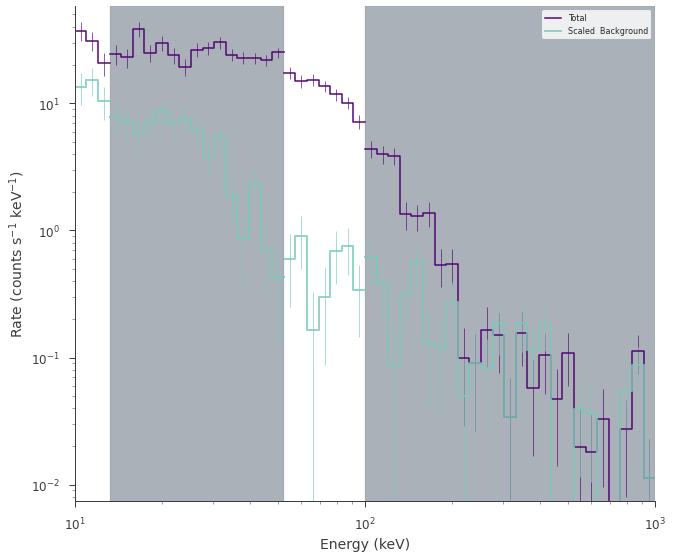

In [9]:
spectrum_generator.set_active_measurements("10-12.5", "56.0-100.0")
fig = spectrum_generator.view_count_spectrum()

which will set the energy range 10-12.5 keV and 56-100 keV to be
 used in the analysis. Note that there is no difference in saying 10 or 10.0.

##### Channel selections:

They are specified as 'c[channel min]-c[channel max]'.

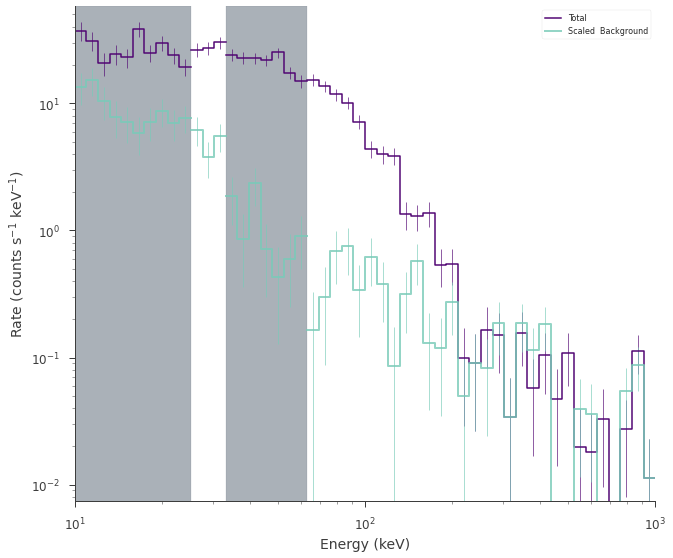

In [10]:
spectrum_generator.set_active_measurements("c10-c12", "c20-c50")
fig = spectrum_generator.view_count_spectrum()

This will set channels 10-12 and 20-50 as active channels to be used in the analysis

##### Mixed channel and energy selections:

You can also specify mixed energy/channel selections, for example to go from 0.2 keV to channel 10 and from channel 20 to 1000 keV:

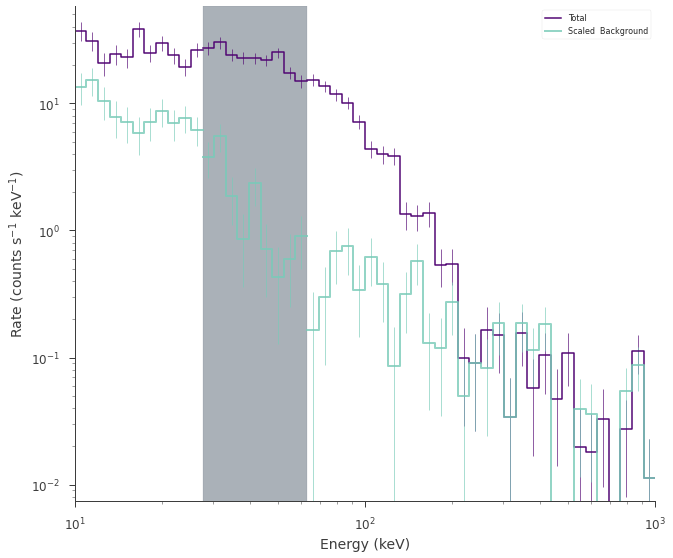

In [11]:
spectrum_generator.set_active_measurements("0.2-c10", "c20-1000")
fig = spectrum_generator.view_count_spectrum()

##### Use all measurements (i.e., reset to initial state):

Use 'all' to select all measurements, as in:


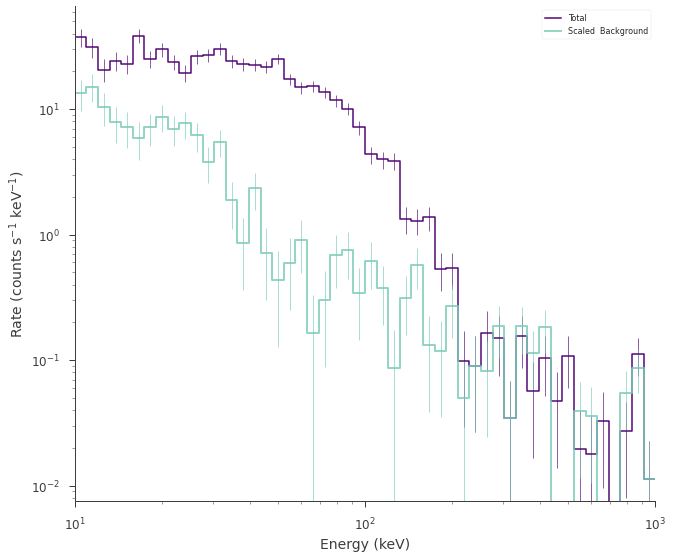

In [12]:
spectrum_generator.set_active_measurements("all")
fig = spectrum_generator.view_count_spectrum()

##### Exclude measurements:

Excluding measurements work as selecting measurements, but with the "exclude" keyword set to the energies and/or channels to be excluded. To exclude between channel 10 and 20 keV and 50 keV to channel 120 do:

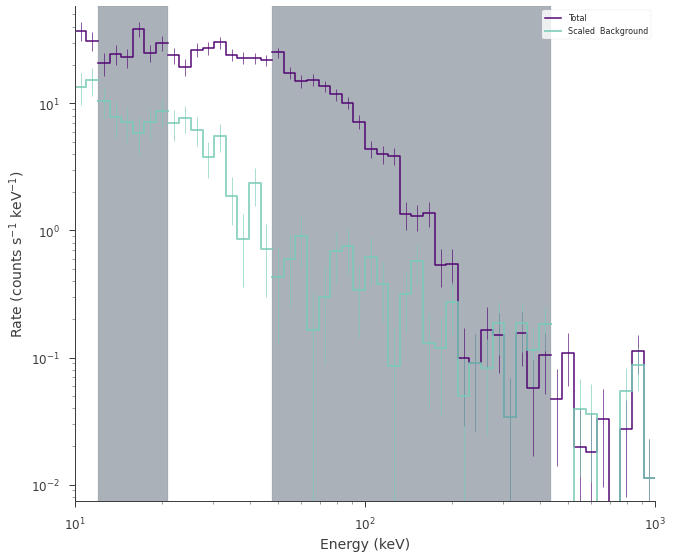

In [13]:
spectrum_generator.set_active_measurements(exclude=["c2-20", "50-c40"])
fig = spectrum_generator.view_count_spectrum()

##### Select and exclude:

Call this method more than once if you need to select and exclude. For example, to select between 0.2 keV and channel 10, but exclude channel 30-50 and energy, do:

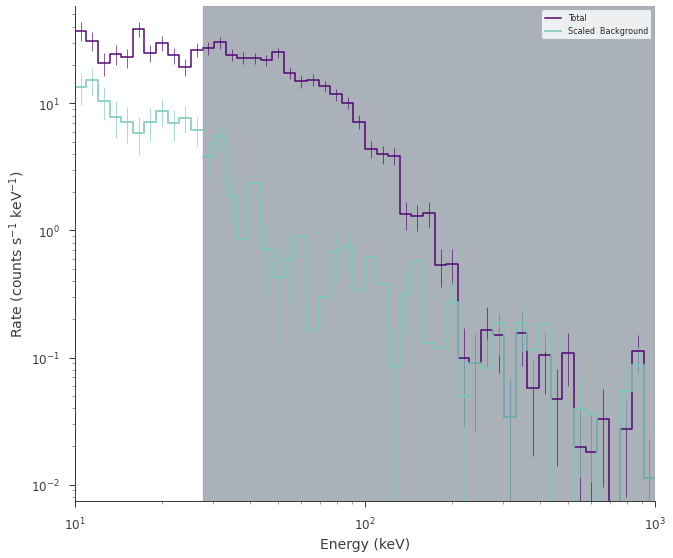

In [14]:
spectrum_generator.set_active_measurements("0.2-c10", exclude=["c30-c50"])
fig = spectrum_generator.view_count_spectrum()

### Rebinning

We can rebin the spectra based off a minimum total or background rate requried. This is useful when using profile likelihoods, however, we do not change the underlying likelihood by binning up the data. For more information, consult the statistics section.

To rebin a spectrum based off the total counts, we specify the minimum counts per bin we would like, say 100:

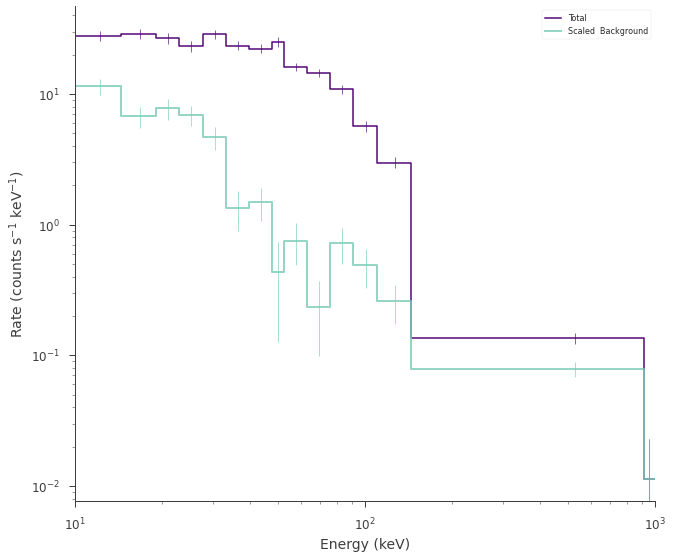

In [15]:
spectrum_generator.set_active_measurements("all")

spectrum_generator.rebin_on_source(100)

fig = spectrum_generator.view_count_spectrum()

We can remove the rebinning this way:

In [16]:
spectrum_generator.remove_rebinning()

Instead, when using a profile likelihood which requires at least one background count per bin to be valid, we would call:

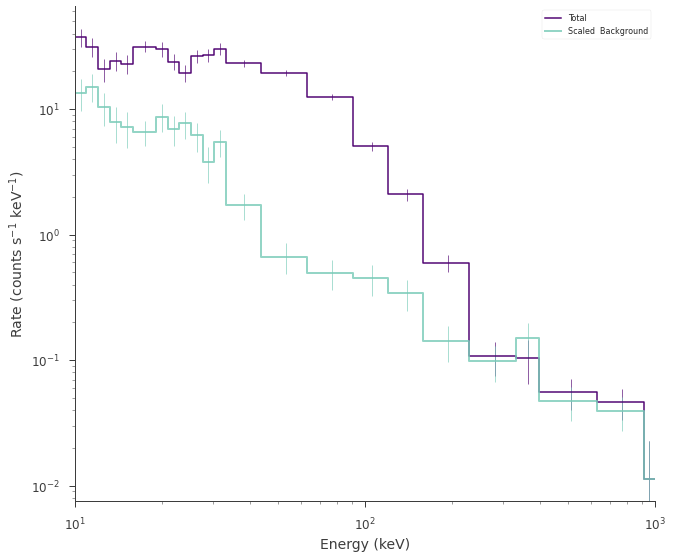

In [17]:
spectrum_generator.rebin_on_background(10)
fig = spectrum_generator.view_count_spectrum()

In [18]:
spectrum_generator.remove_rebinning()

### Fitting

To fit the data, we need to create a function, a PointSouce, a Model, and either a JointLikelihood or BayesianAnalysis object.

In [19]:
bb = Blackbody()

pts = PointSource("mysource", 0, 0, spectral_shape=bb)

model = Model(pts)

# MLE fitting

jl = JointLikelihood(model, DataList(spectrum_generator))

result = jl.fit()

Best fit values:



,result,unit
parameter,,
mysource.spectrum.main.Blackbody.K,(8.5 +/- 0.6) x 10^-2,1 / (cm2 keV3 s)
mysource.spectrum.main.Blackbody.kT,(2.02 +/- 0.04) x 10,keV



Correlation matrix:



1.00,-0.92
-0.92,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,226.561266
total,226.561266



Values of statistical measures:



,statistical measures
AIC,457.377850
BIC,460.946577


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


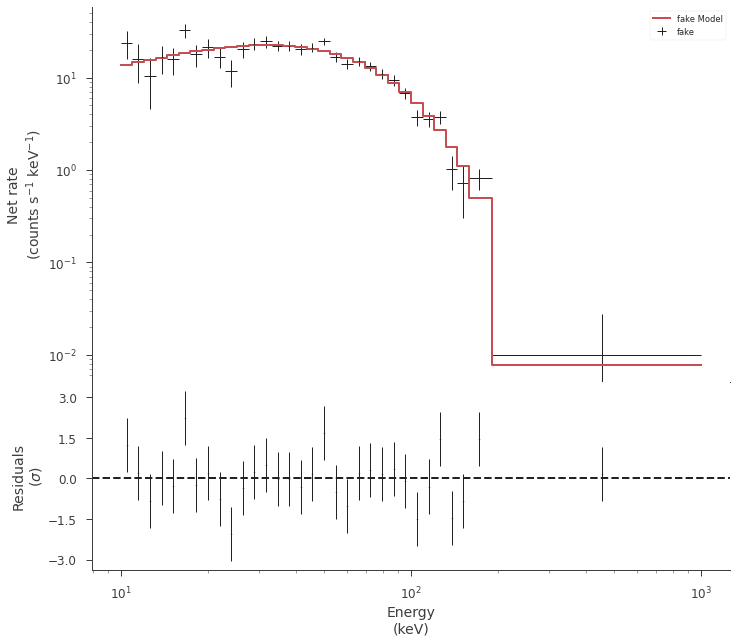

In [20]:
count_fig1 = spectrum_generator.display_model(min_rate=10)

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

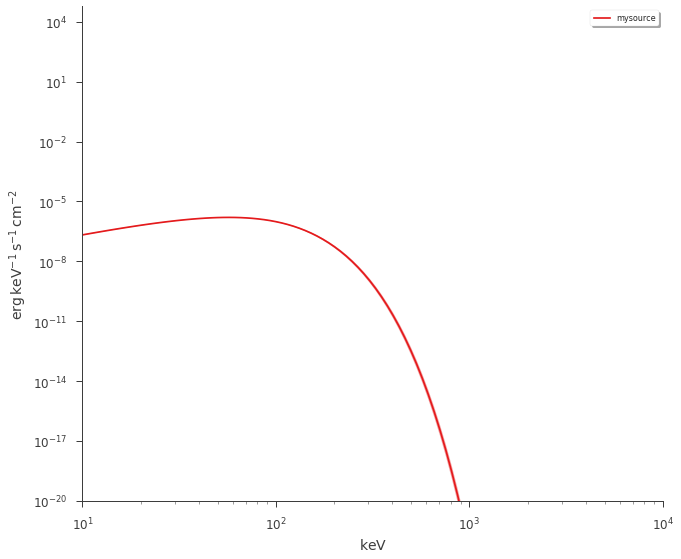

In [21]:
_ = plot_spectra(jl.results, flux_unit="erg/(cm2 s keV)")

_ = plt.ylim(1e-20)

Perhaps we want to fit a different model and compare the results. We change the spectral model and will overplot the fit's expected counts with the fit to the blackbody.

In [22]:
import warnings

pl = Powerlaw()

pts = PointSource("mysource", 0, 0, spectral_shape=pl)

model = Model(pts)

# MLE fitting

jl = JointLikelihood(model, DataList(spectrum_generator))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    result = jl.fit()

Best fit values:



,result,unit
parameter,,
mysource.spectrum.main.Powerlaw.K,(10.00000 +/- 0.00020) x 10^2,1 / (cm2 keV s)
mysource.spectrum.main.Powerlaw.index,-1.340 +/- 0.012,



Correlation matrix:



1.00,0.00
0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,701.577626
total,701.577626



Values of statistical measures:



,statistical measures
AIC,1407.410571
BIC,1410.979298


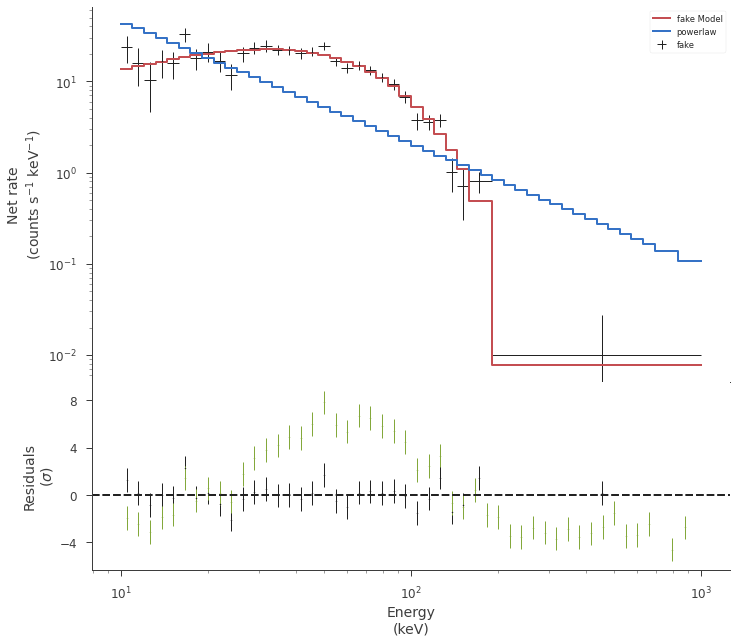

In [23]:
spectrum_generator.display_model(
    min_rate=10,
    show_data=False,
    show_residuals=True,
    data_color="g",
    model_color="b",
    model_label="powerlaw",
    model_subplot=count_fig1.axes,
)

Examining the fit in count space lets us easily see that the fit with the powerlaw model is very poor. We can of course deterimine the fit quality numerically, but this is saved for another section.

## DispersionSpectrumLike

Instruments that exhibit energy dispersion must have their spectra fit through a process called forward folding. Let $R(\varepsilon,E)$ be our response converting between true (monte carlo) energy ($E$) and detector channel/energy ($\varepsilon$), $f(E, \vec{\phi}_{\rm s})$ be our photon model which is a function of $E$ and  source model parameters $\vec{\phi}_{\rm s}$. Then, the source counts ($S_{c} (\vec{\phi}_{\rm s})$) registered in the detector between channel (c) with energy boundaries $E_{{\rm min}, c}$ and  $E_{{\rm max}, c}$ (in the absence of background) are given by the convolution of the photon model with the response:

$$S_{c} (\vec{\phi}_{\rm s}) =
  \int_{0}^\infty {\rm d} E \, f(E, \vec{\phi}_{\rm s})
  \int_{E_{{\rm min}, c}}^{E_{{\rm max}, c}} {\rm d} \varepsilon
  \, R(\varepsilon, E) $$

Therefore, to fit the data in count space, we assume a photon model, fold it through the response, and calculate the predicted counts. This process is iterated on the source model parameters via likelihood minimization or posterior sampling until an optimal set of parameters is found.

To handle dispersed spectra, 3ML provides the **DispersionSpectrumLike** plugin.


In [24]:
from threeML.plugins.DispersionSpectrumLike import DispersionSpectrumLike
from threeML.utils.OGIP.response import OGIPResponse
from threeML.io.package_data import get_path_of_data_file


# we will use a demo response
response = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))


source_function = Broken_powerlaw(K=1e-2, alpha=0, beta=-2, xb=2000, piv=200)

background_function = Powerlaw(K=10, index=-1.5, piv=100.0)

dispersion_spectrum_generator = DispersionSpectrumLike.from_function(
    "test",
    source_function=source_function,
    response=response,
    background_function=background_function,
)

We can view the response and the count spectrum created.

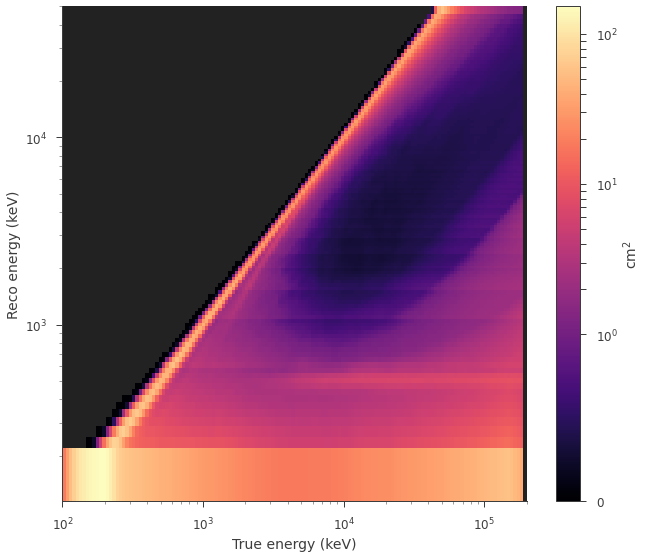

In [25]:
threeML_config.plugins.ogip.response_zero_color = "k"
threeML_config.plugins.ogip.response_cmap = "magma"

_ = dispersion_spectrum_generator.display_rsp()

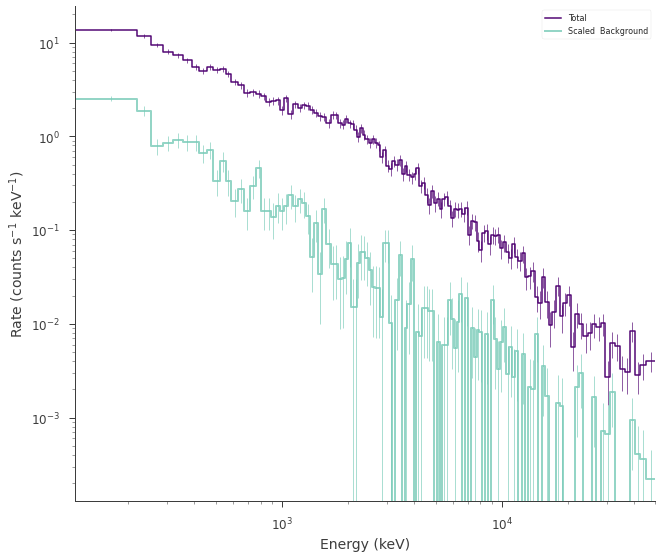

In [26]:
fig = dispersion_spectrum_generator.view_count_spectrum()

All the functionality of **SpectrumLike** is inherited in **DispersionSpectrumLike**. Therefore, fitting, and examination of the data is the same.


## OGIPLike

Finally, many x-ray mission provide data in the form of fits files known and pulse-height analysis (PHA) data. The keywords for the information in the data are known as the Office of Guest Investigators Program (OGIP) standard. While these data are always a form of binned spectra, 3ML provide a convience plugin for reading OGIP standard PHA Type I (single spectrum) and Type II (multiple spectrum) files.

The **OGIPLike** plugin inherits from **DispersionSpectrumLike** and thus needs either a full response or a redistribution matrix (RMF) and ancillary response (ARF) file. The plugin will prove the keywords in the data files to automatically figure out the correct likelihood for the observation.

In [27]:
ogip_data = OGIPLike(
    "ogip",
    observation=get_path_of_data_file("datasets/ogip_powerlaw.pha"),
    background=get_path_of_data_file("datasets/ogip_powerlaw.bak"),
    response=get_path_of_data_file("datasets/ogip_powerlaw.rsp"),
)

In [28]:
ogip_data.display()

,0
pha file,/home/runner/work/threeML/threeML/threeML/data...
bak file,/home/runner/work/threeML/threeML/threeML/data...
n. channels,128
total rate,1.74
total bkg. rate,0.1464
bkg. exposure,5000.0
bkg. is poisson,True
exposure,200.0
is poisson,True
background,profiled


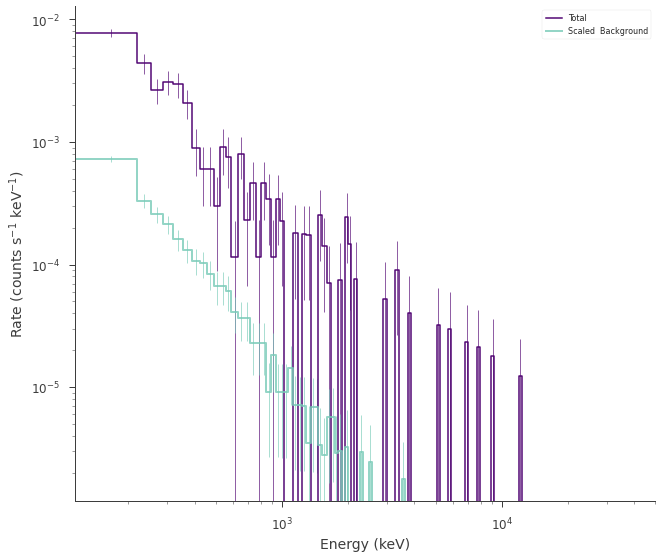

In [29]:
fig = ogip_data.view_count_spectrum()

When using PHA Type II data, a spectrum number must be supplied to indicate which spectrum from the file to use. Users can also follow the XSPEC convention of specifying the spectrum number in the filename (e.g. 'my_pha.fits{1}')